In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from SI_Classes import SI_model, DataScaler
from System_Classes import CascadedTankSystem, LTISystem, WHSystem, CascadedTankSystem_Simplified
from SI_Functions import perform_experiment, generate_input_signals, generate_random_input_signals
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
# Set seed for reproducibility
seed=1
# seed=42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# Define the objective function
def objective_function(w_query, t_query_list, x0_query, si_model, lam):
    # Compute the surprise index
    suprise_index_norm, cunc_std_norm, suprise_index, y_query, unc_std, ppd_std, u_query, t_query = si_model.query_stepinput(t_query_list=t_query_list, w_query=w_query, x0_query=x0_query)
    unc_index = lam * (suprise_index_norm) + (1-lam) * (cunc_std_norm)
    loss = -np.log(unc_index)
    return loss

def numerical_jacobian(w_query, t_query_list, x0_query, si_model, lam):
    # epsilon = np.sqrt(np.finfo(float).eps)  # Small step size
    objective_function_wrt_w_query = lambda w_query: objective_function(w_query, t_query_list=t_query_list, x0_query=x0_query, si_model=si_model, lam=lam)
    epsilon = 1e-2
    return approx_fprime(w_query, objective_function_wrt_w_query, epsilon)

def callback(w_query_k, t_query_list, x0_query, si_model, lam):
    suprise_index_norm, cunc_std_norm, suprise_index, y_query, unc_std, ppd_std, u_query, t_query = si_model.query_stepinput(t_query_list=t_query_list, w_query=w_query_k, x0_query=x0_query)
    unc_index = lam * (suprise_index_norm) + (1-lam) * (cunc_std_norm)
    print("********")
    print(f"unc_index = {unc_index:.2f}")
    print(f"suprise_index = {suprise_index:.2f}")


In [3]:
# True system - Cascaded Tanks
sys = CascadedTankSystem(min_cons_hard_x_step=0, max_cons_hard_x_step=10, min_cons_hard_y_step=0, max_cons_hard_y_step=10, tau_u=0.2, tau_y=0.2, add_noise=True, noise_magnitude=0.0025, return_SNR=True)
x0_denorm = np.array([5, 5, 5, 0])

In [4]:
n_x = sys.n_x
n_u = sys.n_u
n_y = sys.n_y

t_fit  = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]
t_test = [0, 15, 30, 45, 60, 75, 90]
w_fit  = np.array([3, 2, 3, 4, 3.25, 1.75, 2.25, 3.75, 2.75, 2.25, 2.75, 3])
w_test = np.array([3.25, 1.25, 4, 1.75, 3.5, 2])

time_steps_fit_denorm, u_fit_denorm   = generate_input_signals(t_segments_list=t_fit, w_values=w_fit, n_u=n_u)
time_steps_test_denorm, u_test_denorm = generate_input_signals(t_segments_list=t_test, w_values=w_test, n_u=n_u)


y_fit_true_denorm,  x_fit_true_denorm  = sys(u_fit_denorm, x0_denorm)
y_test_true_denorm, x_test_true_denorm = sys(u_test_denorm, x0_denorm)

SNR:  [20.05050529]
SNR:  [18.89822421]


In [5]:
datascaler = DataScaler(
    mu_u=np.mean(u_fit_denorm, axis=0),
    mu_y=np.mean(y_fit_true_denorm, axis=0), 
    mu_x=np.mean(x_fit_true_denorm, axis=0),
    std_u=np.std(u_fit_denorm, axis=0),
    std_y=np.std(y_fit_true_denorm, axis=0), 
    std_x=np.std(x_fit_true_denorm, axis=0),
    mu_offset_u=0*np.mean(u_fit_denorm, axis=0),
    mu_offset_y=0*np.mean(y_fit_true_denorm, axis=0), 
    mu_offset_x=0*np.mean(x_fit_true_denorm, axis=0),  
    )

# Normalizing the Data
u_fit       = datascaler.normalize(u_fit_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
u_test      = datascaler.normalize(u_test_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
y_fit_true  = datascaler.normalize(y_fit_true_denorm, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_test_true = datascaler.normalize(y_test_true_denorm, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
x0          = datascaler.normalize(x0_denorm, datascaler.mu_x, datascaler.std_x, datascaler.mu_offset_x)

# Signals for Counter-Factual Argument
t_fit_cf       = np.copy(t_fit)
u_fit_cf       = np.copy(u_fit)
y_fit_true_cf  = np.copy(y_fit_true)
u_test_cf      = np.copy(u_test)
y_test_true_cf = np.copy(y_test_true)

In [6]:
# Setup neural model structure
hidden_size         = 8
tau_prior           = 0.05
sigma_noise         = 0.05
nn_fit_iters_base   = 100
nn_fit_lr_base      = 1e-3
nn_fit_iters_exp    = 175
nn_fit_lr_exp       = 1e-4
num_experiments     = 2
num_experiments_min = 1
t_query_list        = [0, 15, 30, 45]
t_query_unit        = [0, 15, 30, 45]
t_query_list_cf     = [0, 15, 30, 45]
t_query_unit_cf     = [0, 15, 30, 45]
experiment_length   = t_query_list[-1] - t_query_list[0]
lam                 = 0.1
lam_w               = 0.9
w_querry_ub_denorm  = 4
w_querry_lb_denorm  = 2
n_opt_iter          = 10
options             = {'maxiter': n_opt_iter, 'disp': True}
tol_w_query         = 1e-3

In [7]:
from NN_Classes import NeuralLinStateUpdate, NeuralLinOutput, CTSNeuralStateSpace
si_model = SI_model(n_x, n_u, n_y, hidden_size, dtype=torch.float32, device=torch.device("cpu"), tau_prior=tau_prior, sigma_noise=sigma_noise, modify_si=False, f_class=NeuralLinStateUpdate, g_class=NeuralLinOutput)
# si_model = SI_model(n_x, n_u, n_y, hidden_size, dtype=torch.float32, device=torch.device("cpu"), tau_prior=tau_prior, sigma_noise=sigma_noise, modify_si=False, f_class=CTSNeuralStateSpace, g_class=NeuralLinOutput)
objective_function_wrt_w_query = lambda w_query: objective_function(w_query, t_query_list=t_query_list, x0_query=x0, si_model=si_model, lam=lam)
numerical_jacobian_wrt_w_query = lambda w_query: numerical_jacobian(w_query, t_query_list=t_query_list, x0_query=x0, si_model=si_model, lam=lam)
callback_wrt_w_query           = lambda w_query: callback(w_query, t_query_list=t_query_list, x0_query=x0, si_model=si_model, lam=lam)
print("---------------------------------------------------------------------------------")
print('Experiment Number #0:')
print(" Training the Model on the Initial Dataset: ")
_, _, loss_fit = si_model.nn_fit(u_fit=u_fit , y_fit=y_fit_true, x0=x0, num_iter=nn_fit_iters_base, lr=nn_fit_lr_base, print_freq=25, return_loss=True)
y_test, _      = si_model.nn_predict(u_pred=u_test, x0_pred=x0)
loss_test = np.mean((y_test - y_test_true)**2)
print(f"Prediction Loss {loss_test:.4f}")
_, _, _, _, _, _, _, _ = si_model.compute_fit_cov(u_fit=u_fit, x0_fit=x0)

w_querry_ub     = datascaler.normalize(w_querry_ub_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
w_querry_lb     = datascaler.normalize(w_querry_lb_denorm, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
w_query_bounds  = [(w_querry_lb, w_querry_ub)]
w_query_perturb = np.random.uniform(low=w_querry_lb, high=w_querry_ub, size=len(t_query_list)-1)
w_query_opt     = w_query_perturb
t_query_opt     = t_fit

fitting_loss_history    = [loss_fit]
prediction_loss_history = [loss_test]
suprise_index_history   = []
unc_index_history       = []

for experiment_idx in range(1, num_experiments + 1):
    print("---------------------------------------------------------------------------------")
    print(f'Experiment Number #{experiment_idx}:')
    t_offset = t_query_opt[-1]
    t_query_list = t_offset + np.array(t_query_unit)
    w_query_init = lam_w * w_query_opt + (1- lam_w)*w_query_perturb 
    print("=====================")
    print(" Finding Optimal u: ")
    method = 'L-BFGS-B'
    result = minimize(objective_function_wrt_w_query, w_query_init, method=method, bounds=w_query_bounds, options=options, callback=callback_wrt_w_query, jac=numerical_jacobian_wrt_w_query)
    # method = 'nelder-mead'
    # result = minimize(objective_function_wrt_w_query, w_query_init, method=method, bounds=w_query_bounds, options=options)
    print(f"Optimization Result: x = {result.x}, Success: {result.success}, Message: {result.message}")
    w_query_opt_prev = w_query_opt
    w_query_opt = result.x
    #===========================================================================================================================================================================
    suprise_index_norm_opt, cunc_std_norm_opt, suprise_index_opt, y_query_opt, unc_std_opt, ppd_std_opt, u_query_opt, t_query_opt = si_model.query_stepinput(t_query_list=t_query_list, w_query=w_query_opt, x0_query=x0)
    #===========================================================================================================================================================================
    print(f'Optimized Surprise Index: {suprise_index_opt:.2f}')
    y_query_opt_true, _ = perform_experiment(sys, u_query_opt, x0, datascaler)
    print("=====================")
    #===========================================================================================================================================================================
    u_fit      = np.concat([u_fit, u_query_opt])
    y_fit_true = np.concat([y_fit_true, y_query_opt_true])
    print(" Retraining the Model on the Extended Dataset: ")
    y_fitted, _, loss_fit = si_model.nn_fit(u_fit=u_fit , y_fit=y_fit_true, x0=x0, num_iter=nn_fit_iters_exp, lr=nn_fit_lr_exp, print_freq=25, return_loss=True)
    y_test, x_test = si_model.nn_predict(u_pred=u_test, x0_pred=x0)
    loss_test = np.mean((y_test - y_test_true)**2)
    print(f"Prediction Loss {loss_test:.4f}")
    prediction_loss_history.append(loss_test)
    fitting_loss_history.append(loss_fit)
    suprise_index_history.append(suprise_index_opt)
    unc_index_history.append(lam * (suprise_index_norm_opt) + (1-lam) * (cunc_std_norm_opt))
    #===========================================================================================================================================================================
    _, _, _, _, _, _, _, _ = si_model.compute_fit_cov(u_fit=u_fit, x0_fit=x0)
    #===========================================================================================================================================================================
    # Stopping Criteria
    if np.linalg.norm(w_query_opt - w_query_opt_prev) < tol_w_query and experiment_idx >= num_experiments_min:
        print("Experiments Sequence Was Halted: ")
        print("Repeatative Input Sequence for Experiment")
        print(f"norm(w_query_opt, w_query_opt_prev) < tol_w_query: {np.linalg.norm(w_query_opt - w_query_opt_prev)} < {tol_w_query}")
        break

---------------------------------------------------------------------------------
Experiment Number #0:
 Training the Model on the Initial Dataset: 
Iter 0 | Fit Loss 1.7761
Iter 25 | Fit Loss 1.0157
Iter 50 | Fit Loss 0.1743
Iter 75 | Fit Loss 0.0289
Iter 99 | Fit Loss 0.0115
Prediction Loss 0.1106
---------------------------------------------------------------------------------
Experiment Number #1:
 Finding Optimal u: 
********
unc_index = 0.50
suprise_index = 4.86
********
unc_index = 1.14
suprise_index = 11.91
********
unc_index = 1.27
suprise_index = 13.66
********
unc_index = 2.78
suprise_index = 37.10
********
unc_index = 2.85
suprise_index = 38.13
********
unc_index = 2.86
suprise_index = 38.27
********
unc_index = 2.86
suprise_index = 38.30
********
unc_index = 2.86
suprise_index = 38.31
********
unc_index = 3.89
suprise_index = 53.41
********
unc_index = 4.80
suprise_index = 67.21
Optimization Result: x = [ 1.83679933 -0.39725124 -0.17323031], Success: False, Message: STOP: 

In [8]:
si_model_cf = SI_model(n_x, n_u, n_y, hidden_size, dtype=torch.float32, device=torch.device("cpu"), tau_prior=tau_prior, sigma_noise=sigma_noise, modify_si=False)
print("---------------------------------------------------------------------------------")
print('Counter-Factual Experiment Number #0:')
print(" Training the Model on the Initial Dataset: ")
_, _, loss_fit_cf = si_model_cf.nn_fit(u_fit=u_fit_cf , y_fit=y_fit_true_cf, x0=x0, num_iter=nn_fit_iters_base, lr=nn_fit_lr_base, print_freq=25, return_loss=True)
y_test_cf, _      = si_model_cf.nn_predict(u_pred=u_test, x0_pred=x0)
loss_test_cf = np.mean((y_test_cf - y_test_true_cf)**2)
print(f"Counter-Factual Prediction Loss {loss_test_cf:.4f}")
_, _, _, _, _, _, _, _ = si_model_cf.compute_fit_cov(u_fit=u_fit_cf, x0_fit=x0)
t_query_cf = t_fit_cf

fitting_loss_history_cf    = [loss_fit_cf]
prediction_loss_history_cf = [loss_test_cf]
suprise_index_history_cf   = []
unc_index_history_cf       = []

for experiment_idx_cf in range(1, num_experiments + 1):
    print("---------------------------------------------------------------------------------")
    print(f'Counter-Factual Experiment Number #{experiment_idx_cf}:')
    t_offset_cf = t_query_cf[-1]
    t_query_list_cf = t_offset_cf + np.array(t_query_unit_cf)
    w_query_cf = np.random.uniform(low=w_querry_lb, high=w_querry_ub, size=len(t_query_list_cf)-1)
    #===========================================================================================================================================================================
    suprise_index_norm_cf, cunc_std_norm_cf, suprise_index_cf, y_query_cf, unc_std_cf, ppd_std_cf, u_query_cf, t_query_cf = si_model_cf.query_stepinput(t_query_list=t_query_list_cf, w_query=w_query_cf, x0_query=x0)
    #===========================================================================================================================================================================
    print(f'Optimized Surprise Index: {suprise_index_cf:.2f}')
    y_query_cf_true, _ = perform_experiment(sys, u_query_cf, x0, datascaler)
    print("=====================")
    #===========================================================================================================================================================================
    u_fit_cf      = np.concat([u_fit_cf, u_query_cf])
    y_fit_true_cf = np.concat([y_fit_true_cf, y_query_cf_true])
    print(" Retraining the Model on the Extended Dataset: ")
    y_fitted_cf, _, loss_fit_cf = si_model_cf.nn_fit(u_fit=u_fit_cf, y_fit=y_fit_true_cf, x0=x0, num_iter= nn_fit_iters_exp, lr=nn_fit_lr_exp, print_freq=25, return_loss=True)
    y_test_cf, _      = si_model_cf.nn_predict(u_pred=u_test_cf, x0_pred=x0)
    print(f"")
    loss_test_cf = np.mean((y_test_cf - y_test_true_cf)**2)
    print(f"Prediction Loss {loss_test_cf:.4f}")
    prediction_loss_history_cf.append(loss_test_cf)
    fitting_loss_history_cf.append(loss_fit_cf)
    suprise_index_history_cf.append(suprise_index_cf)
    unc_index_history_cf.append(lam * (suprise_index_norm_cf) + (1-lam) * (cunc_std_norm_cf))
    #===========================================================================================================================================================================
    _, _, _, _, _, _, _, _ = si_model_cf.compute_fit_cov(u_fit=u_fit_cf, x0_fit=x0)

---------------------------------------------------------------------------------
Counter-Factual Experiment Number #0:
 Training the Model on the Initial Dataset: 
Iter 0 | Fit Loss 1.7761
Iter 25 | Fit Loss 1.0157
Iter 50 | Fit Loss 0.1743
Iter 75 | Fit Loss 0.0289
Iter 99 | Fit Loss 0.0115
Counter-Factual Prediction Loss 0.1106
---------------------------------------------------------------------------------
Counter-Factual Experiment Number #1:
Optimized Surprise Index: 7.05
SNR:  [23.63177455]
 Retraining the Model on the Extended Dataset: 
Iter 0 | Fit Loss 3.5135
Iter 25 | Fit Loss 1.1885
Iter 50 | Fit Loss 1.0998
Iter 75 | Fit Loss 1.0014
Iter 100 | Fit Loss 0.9295
Iter 125 | Fit Loss 0.8859
Iter 150 | Fit Loss 0.8551
Iter 174 | Fit Loss 0.8315

Prediction Loss 0.0760
---------------------------------------------------------------------------------
Counter-Factual Experiment Number #2:
Optimized Surprise Index: 9.02
SNR:  [22.38254051]
 Retraining the Model on the Extended Data

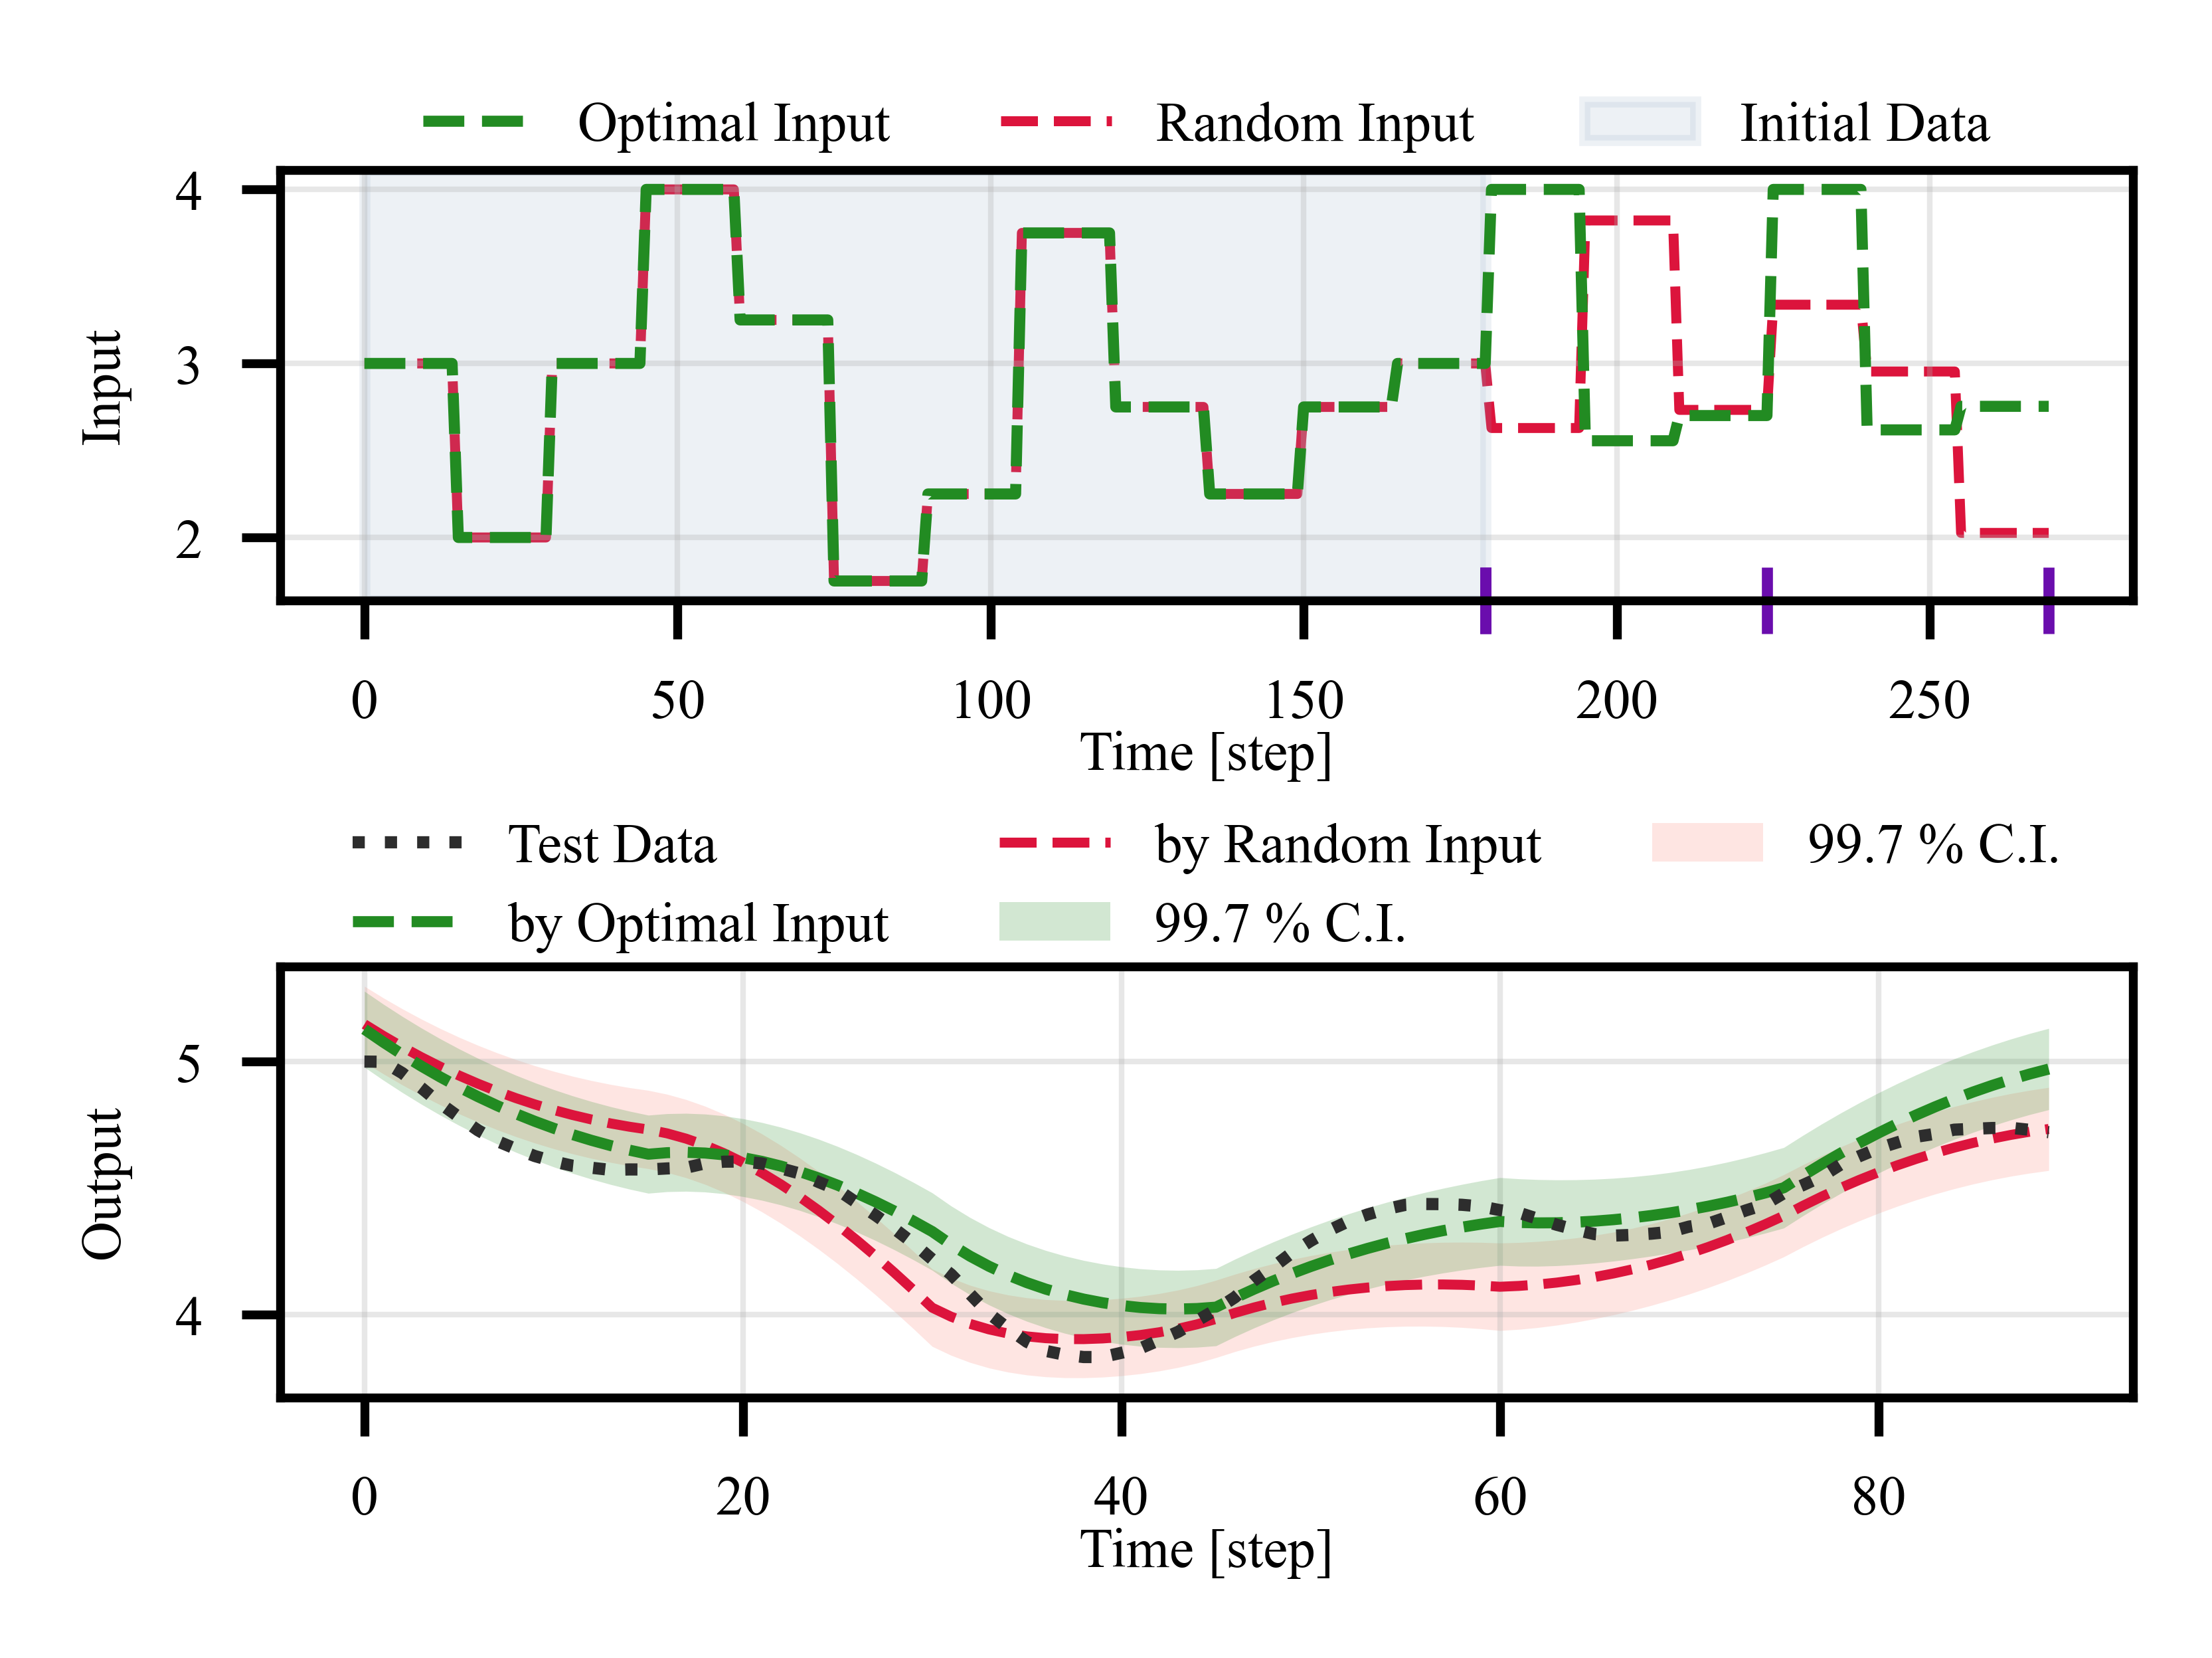

In [9]:
u_fit_cf_denorm  = datascaler.denormalize(u_fit_cf, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
u_fit_opt_denorm = datascaler.denormalize(u_fit, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u)
suprise_index_norm_opt, cunc_std_norm_opt, suprise_index_opt, y_query_opt, unc_std_opt, ppd_std_opt, u_query_opt, t_query_opt = si_model.query_stepinput(t_query_list=t_test, w_query=datascaler.normalize(w_test, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u), x0_query=x0)
suprise_index_norm_cf,  cunc_std_norm_cf,  suprise_index_cf,  y_query_cf,  unc_std_cf,  ppd_std_cf,  u_query_cf,  t_query_cf  = si_model_cf.query_stepinput(t_query_list=t_test, w_query=datascaler.normalize(w_test, datascaler.mu_u, datascaler.std_u, datascaler.mu_offset_u), x0_query=x0)
y_test_true_denorm = datascaler.denormalize(y_test_true, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_test_denorm      = datascaler.denormalize(y_query_opt, datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
y_test_cf_denorm   = datascaler.denormalize(y_query_cf,  datascaler.mu_y, datascaler.std_y, datascaler.mu_offset_y)
ppd_std_test_denorm = ppd_std_opt
ppd_std_test_cf_denorm = ppd_std_cf

# Line width and figure settings
lw = 0.9  # Line width
dpi = 1200
fs = 5
colors = ["#2D2D2D", "#1F77B4", "#228B22", "salmon", "#6A0DAD", "#8AA7C1", "crimson"]

# Configure font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = fs
plt.rcParams.update({'font.size': fs})

# Create a 2x1 subplot layout
fig, axs = plt.subplots(2, 1, figsize=(3, 2), dpi=dpi, gridspec_kw={'height_ratios': [1, 1]})

# First plot (Input)
axs[0].plot(u_fit_opt_denorm, label="Optimal Input", linewidth=lw+0.1, linestyle='--', color=colors[2], zorder=2)
axs[0].plot(u_fit_cf_denorm, label="Random Input", linewidth=lw, linestyle='--', color=colors[6], zorder=1)
axs[0].axvspan(0, t_fit[-1]-1, color=colors[5], alpha=0.15, label="Initial Data")
axs[0].set_ylabel("Input")
axs[0].set_xlabel("Time [step]", labelpad = 0.1)
axs[0].grid(True, alpha=0.3, linewidth=0.5)

xtick_values_minor = [t_fit[-1]-1] + [t_fit[-1]-1 + experiment_length * x for x in range(experiment_idx+1)]
axs[0].set_xticks(xtick_values_minor, minor=True)
axs[0].tick_params(axis='x', which='minor', length=6, width=1, color=colors[4], direction='inout')

# Add legend for the first subplot above it
axs[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.275), ncol=3, fontsize=fs, frameon=False)

# Second plot (Output)
axs[1].plot(y_test_true_denorm, label="Test Data", linewidth=lw+0.2, linestyle=':', color=colors[0], zorder=5)
axs[1].plot(y_test_denorm, label="by Optimal Input", linewidth=lw+0.1, linestyle='--', color=colors[2], zorder=4)
axs[1].plot(y_test_cf_denorm, label="by Random Input", linewidth=lw, linestyle='--', color=colors[6], zorder=3)
axs[1].fill_between(t_query_opt, 
                     y_test_denorm.ravel() - 3 * ppd_std_test_denorm.ravel(),
                     y_test_denorm.ravel() + 3 * ppd_std_test_denorm.ravel(),
                     color=colors[2], alpha=0.2, label="99.7 % C.I.", linewidth=0, zorder=2)
axs[1].fill_between(t_query_cf, 
                     y_test_cf_denorm.ravel() - 3 * ppd_std_test_cf_denorm.ravel(),
                     y_test_cf_denorm.ravel() + 3 * ppd_std_test_cf_denorm.ravel(),
                     color=colors[3], alpha=0.2, label="99.7 % C.I.", linewidth=0, zorder=1)
axs[1].set_ylabel("Output")
axs[1].set_xlabel("Time [step]", labelpad = 0.1)
axs[1].grid(True, alpha=0.3, linewidth=0.5)

# Add legend for the second subplot above it
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=fs, frameon=False)
plt.subplots_adjust(hspace=0.85)
plt.savefig('ExperimentDesign_Performance.pdf', dpi=dpi, bbox_inches='tight')
